In [1]:
import pandas as pd
from transformers import DistilBertForTokenClassification, DistilBertTokenizerFast, DistilBertModel
from transformers import get_linear_schedule_with_warmup, AdamW

import torch.nn.functional as F
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import random
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
# Hyperparams
max_length = 100
batch_size = 64
learning_rate = 2e-05
epochs = 10

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Prepare data

In [5]:
class AddressDataset(Dataset):
    def __init__(self, tokenizer, sentences, targets, max_len):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.targets = targets
        self.max_len = max_len
        targets = ['B-STR', 'I-STR', 'B-POI', 'I-POI', 'O']
        self.tags = dict(zip(targets, range(len(targets))))
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        text_data = self.sentences[index]
        tokenized_inputs = self.tokenizer(
            text_data, is_split_into_words=True,
            add_special_tokens=True, truncation=True, 
            max_length=self.max_len, padding='max_length'
        )
        
        tokenized_inputs = self.align_labels(tokenized_inputs, self.targets[index])
        
        return {
            'ids': torch.tensor(tokenized_inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(tokenized_inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(tokenized_inputs['labels'], dtype=torch.long)
        }
    
    def align_labels(self, tokenized_input, target):
        labels = []
        word_ids = tokenized_input.word_ids()
        
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            else:
                labels.append(self.tags[target[word_idx]])

        tokenized_input['labels'] = labels
        
        return tokenized_input

In [6]:
# Define basics
tokenizer = DistilBertTokenizerFast.from_pretrained('cahya/distilbert-base-indonesian')

In [7]:
df = pd.read_csv('data/formatted_train.csv')
df['tokens'] = df['tokens'].apply(lambda x: eval(x))
df['ner_tags'] = df['ner_tags'].apply(lambda x: eval(x))

train_df, eval_df = train_test_split(df, test_size=0.2, random_state=2021)

In [8]:
train_data = AddressDataset(tokenizer, train_df.tokens.values, train_df.ner_tags.values, max_length)
eval_data = AddressDataset(tokenizer, eval_df.tokens.values, eval_df.ner_tags.values, max_length)

In [9]:
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)

# Prepare model

In [10]:
class IndoDistilBertExtractor(nn.Module):
    def __init__(self):
        super(IndoDistilBertExtractor, self).__init__()
        self.encoder = DistilBertModel.from_pretrained('cahya/distilbert-base-indonesian')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 5)
        
    def forward(self, ids, attn_mask):
        outputs = self.encoder(ids, attention_mask=attn_mask)
        outputs = self.dropout(outputs[0])
        outputs = self.classifier(outputs)
        
        return outputs

In [11]:
model = IndoDistilBertExtractor()
model.to(device)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 102 different named parameters.

==== Embedding Layer ====

encoder.embeddings.word_embeddings.weight               (32000, 768)
encoder.embeddings.position_embeddings.weight             (512, 768)
encoder.embeddings.LayerNorm.weight                           (768,)
encoder.embeddings.LayerNorm.bias                             (768,)
encoder.transformer.layer.0.attention.q_lin.weight        (768, 768)

==== First Transformer ====

encoder.transformer.layer.0.attention.q_lin.bias              (768,)
encoder.transformer.layer.0.attention.k_lin.weight        (768, 768)
encoder.transformer.layer.0.attention.k_lin.bias              (768,)
encoder.transformer.layer.0.attention.v_lin.weight        (768, 768)
encoder.transformer.layer.0.attention.v_lin.bias              (768,)
encoder.transformer.layer.0.attention.out_lin.weight      (768, 768)
encoder.transformer.layer.0.attention.out_lin.bias            (768,)
encoder.transformer.layer.0.sa_layer_norm.weight              (

# Training

In [12]:
# Create custom focal loss that inherits cross entropy loss
class FocalLoss(nn.CrossEntropyLoss):
    def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma
        
    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss) if self.reduction == 'mean' else torch.sum(loss) if self.reduction == 'sum' else loss

In [13]:
optimizer = AdamW(params=model.parameters(), lr=learning_rate, eps=1e-8)
criterion = FocalLoss(gamma=2, reduction='mean')
# criterion = nn.CrossEntropyLoss()

In [14]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [15]:
loss_values = []
train_acc = []

eval_loss_vals = []
eval_acc_vals = []

for epoch_i in tqdm(range(epochs)):
    print('Training...')
    
    t0 = time.time()
    total_loss = 0
    total_accuracy = 0
    
    # set model to train mode
    model.train()
    
    for index, batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        input_ids = batch['ids'].to(device)
        attn_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)
        
        model.zero_grad()
        outputs = model(input_ids, attn_mask)
        
        active_loss = attn_mask.view(-1) == 1
        active_logits = outputs.view(-1, 5)
        active_labels = torch.where(active_loss, labels.view(-1), torch.tensor(criterion.ignore_index).type_as(labels))
        
        loss = criterion(active_logits, active_labels)
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        active_logits = active_logits.detach().cpu().numpy()
        active_labels = active_labels.detach().cpu().numpy()
        
        total_accuracy += (active_logits.argmax(axis=1) == active_labels).sum() / len(active_labels)
    
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = total_accuracy / len(train_dataloader)
    
    loss_values.append(avg_train_loss)
    train_acc.append(avg_train_acc)
    
    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Average training acc: {0:.3f}".format(avg_train_acc))
    
    print("")
    print("Running Validation")
    
    # Set to eval mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_samples = 0, 0
    
    for index, batch in tqdm(enumerate(eval_dataloader), total=len(eval_dataloader)):
        input_ids = batch['ids'].to(device)
        attn_mask = batch['mask'].to(device)
        labels = batch['targets'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attn_mask)
            
        active_loss = attn_mask.view(-1) == 1
        active_logits = outputs.view(-1, 5)
        active_labels = torch.where(active_loss, labels.view(-1), torch.tensor(criterion.ignore_index).type_as(labels))
        
        loss = criterion(active_logits, active_labels)
        eval_loss += loss.mean().item()
        
        active_logits = active_logits.detach().cpu().numpy()
        active_labels = active_labels.detach().cpu().numpy()
        
        eval_accuracy += (active_logits.argmax(axis=1) == active_labels).sum() / len(active_labels)
        nb_eval_steps += 1
        
    eval_loss = eval_loss/nb_eval_steps
    eval_acc = eval_accuracy/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_acc))
    
    eval_loss_vals.append(eval_loss)
    eval_acc_vals.append(eval_acc)

Training...




  Average training loss: 0.007
  Average training acc: 0.079

Running Validation



Validation loss: 0.0035935913177598307
Validation Accuracy: 0.08245502398720687
Training...




  Average training loss: 0.003
  Average training acc: 0.083

Running Validation



Validation loss: 0.0028927575621599043
Validation Accuracy: 0.08382012926439238
Training...




  Average training loss: 0.002
  Average training acc: 0.085

Running Validation



Validation loss: 0.0026893350298204687
Validation Accuracy: 0.08427022254797442
Training...




  Average training loss: 0.002
  Average training acc: 0.086

Running Validation



Validation loss: 0.0026360825595901664
Validation Accuracy: 0.08449576892324098
Training...




  Average training loss: 0.002
  Average training acc: 0.087

Running Validation



Validation loss: 0.0026357125213269444
Validation Accuracy: 0.08465185234541586
Training...




  Average training loss: 0.001
  Average training acc: 0.087

Running Validation



Validation loss: 0.0027268735426867795
Validation Accuracy: 0.08468133662046906
Training...




  Average training loss: 0.001
  Average training acc: 0.088

Running Validation



Validation loss: 0.0028061218071554696
Validation Accuracy: 0.08471115405117276
Training...




  Average training loss: 0.001
  Average training acc: 0.088

Running Validation



Validation loss: 0.002922245210054259
Validation Accuracy: 0.0846450226545842
Training...




  Average training loss: 0.001
  Average training acc: 0.089

Running Validation



Validation loss: 0.003006193226098822
Validation Accuracy: 0.08467217484008535
Training...




  Average training loss: 0.001
  Average training acc: 0.089

Running Validation



Validation loss: 0.003032464066335161
Validation Accuracy: 0.08464369003198284



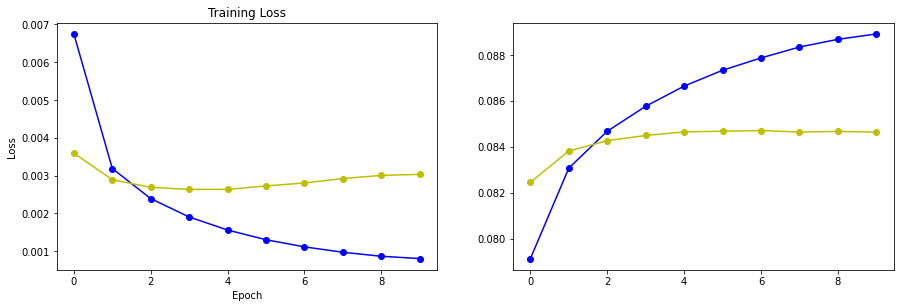

In [18]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values, 'b-o')
plt.plot(eval_loss_vals, 'y-o')

plt.subplot(222)
plt.plot(train_acc, 'b-o')
plt.plot(eval_acc_vals, 'y-o')

In [19]:
# Save model
# model.save_pretrained('weights/ner_distil_bert_indo')
torch.save(model, 'weights/ner_distil_indo.pt')